In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
import statsmodels.api as sm

from numpy import log
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from matplotlib.ticker import PercentFormatter

# Escenario base EPR

## Modelo variables macro  Colombia 2019-2021

Se trabajaran con las series historicas, para el PIB se utilizara la serie historica de la tasa de crecimiento anual (con frecuencia trimestral) con ventana de tiempo 2009-2018. Para el desempleo la tasa de desempleo total con frecuencia trimestral en el periodo 2009-2018. Para el IPC, la DTF, la IBR se utilizara la serie mensual para el periodo 2010-2018.Para el petroleo se utiliza la serie mensual del precio del Brent en dolares en el periodo (2009-2018). La fuente de estos datos es: el DANE, el Banco de la Republica y Macrotrends LLC.

In [2]:
macro = pd.read_csv("macro.csv")
pib = pd.read_csv("pib.csv")['pib']
brent = pd.read_csv("brent.csv")['brent']
inf= macro[macro.columns[2]]
des= macro[macro.columns[3]]
ipc = pd.read_csv('ipc.csv')
indipc = ipc[ipc.columns[2]]
ipca = ipc[ipc.columns[3]]
banrep = ipc[ipc.columns[4]]
ipc = ipc[ipc.columns[1]]
dtfm = pd.read_csv('dtf.csv')
ibrm = dtfm[dtfm.columns[2]]
dtfm = dtfm[dtfm.columns[1]]

###  Modelo del PIB

Para modelar el PIB se decide utilizar un modelo autoregresivo integrado de media movil con componente estacional, se buscan los valores óptimos para los parametros p, d, q, P,D,Q. El criterio para la selección de estos es el AIC. Como se puede observar en la siguiente tabla, el menor AIC es generado con un SARIMAX(0, 0, 0) (2, 2, 1).

In [3]:
trainpib = pib[:41]
testpib = pib[41:]

In [4]:
modelpib = pm.auto_arima(trainpib, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=4,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality 
                      D=2,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)


Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 2, 1, 4); AIC=121.759, BIC=127.745, Fit time=0.363 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 2, 0, 4); AIC=143.148, BIC=146.141, Fit time=0.014 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 2, 0, 4); AIC=133.721, BIC=139.707, Fit time=0.088 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 2, 1, 4); AIC=123.033, BIC=129.019, Fit time=0.382 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 2, 1, 4); AIC=121.836, BIC=126.326, Fit time=0.267 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(2, 2, 1, 4); AIC=119.731, BIC=127.213, Fit time=0.432 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(2, 2, 0, 4); AIC=127.017, BIC=133.003, Fit time=0.095 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(2, 2, 2, 4); AIC=120.137, BIC=129.116, Fit time=0.719 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 2, 0, 4); AIC=132.837, BIC=137.327, Fit time=0.051 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 2, 1, 4);

A continuación se presenta el resumen del modelo que presento los mejores resultados:

In [5]:
print(modelpib.summary())

                            Statespace Model Results                           
Dep. Variable:                       y   No. Observations:                   41
Model:             SARIMAX(2, 2, 1, 4)   Log Likelihood                 -54.865
Date:                 Mon, 09 Sep 2019   AIC                            119.731
Time:                         16:04:38   BIC                            127.213
Sample:                              0   HQIC                           122.248
                                  - 41                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0186      0.107      0.174      0.862      -0.192       0.229
ar.S.L4       -0.4393      0.284     -1.546      0.122      -0.996       0.118
ar.S.L8       -0.4302      0.240     -1.790 

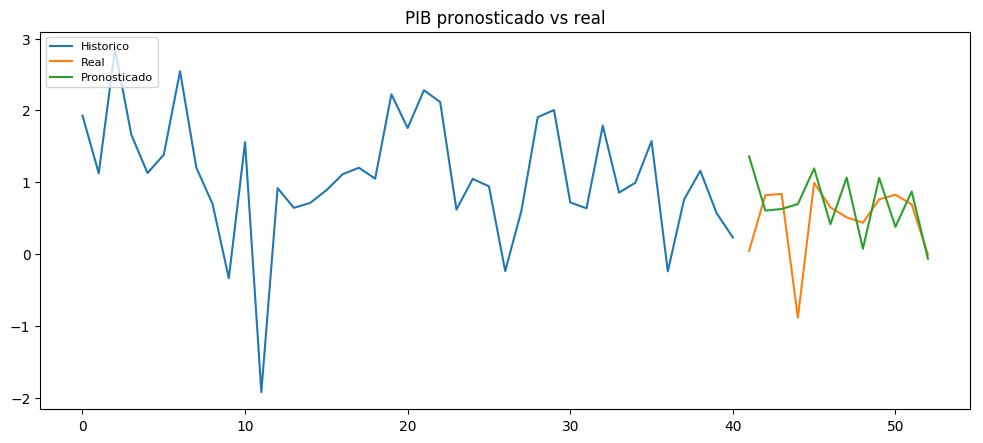

In [6]:
model = SARIMAX(trainpib, order=(0,0,0 )  , seasonal_order=(2, 2,1, 4))
fitted = model.fit(disp=-1)  
fc = fitted.forecast(24, alpha=0.05)
fc_series = pd.Series(fc, index=testpib.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(trainpib, label='Historico')
plt.plot(testpib, label='Real')
plt.plot(fc_series, label='Pronosticado')
plt.title('PIB pronosticado vs real')
plt.legend(loc='upper left', fontsize=8)
plt.show()

 El resultado del backtest muestra menor volatilidad y picos con una peridiocidad mayor a la del real, por esto de decide probar con un Sarimax(0,0,0)x(0,2,1). Este modelo tiene un AIC (criterio de selección en este caso) similar al del modelo sugerido por el auto arima.  Como se puede observar a continuación el modelo se ajusta mejor con respecto al anterior.

/home/carlos/Documentos/venv/lib/python3.5/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


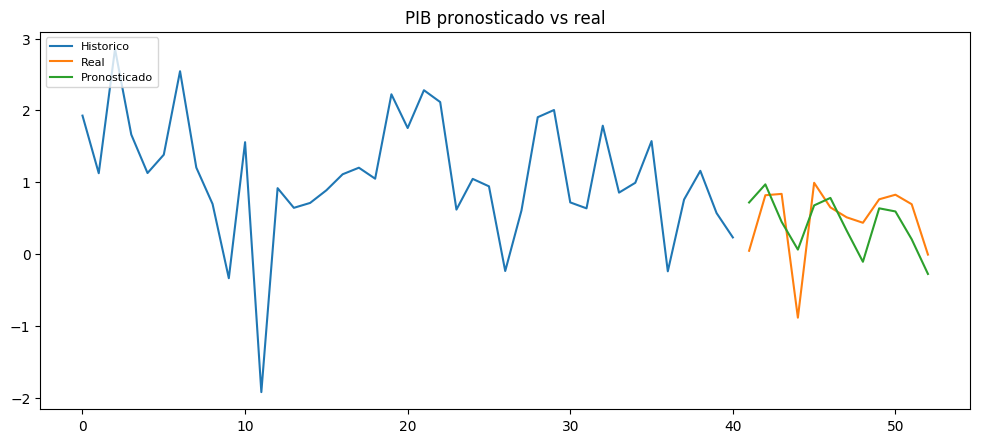

In [7]:
model = SARIMAX(trainpib, order=(0,0,0 )  , seasonal_order=(0, 2,1, 4))
fitted = model.fit(disp=-1)  
fc = fitted.forecast(24, alpha=0.05)
fc_series = pd.Series(fc, index=testpib.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(trainpib, label='Historico')
plt.plot(testpib, label='Real')
plt.plot(fc_series, label='Pronosticado')
plt.title('PIB pronosticado vs real')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [8]:
print(fitted.summary())

                            Statespace Model Results                           
Dep. Variable:                     pib   No. Observations:                   41
Model:             SARIMAX(0, 2, 1, 4)   Log Likelihood                 -57.997
Date:                 Mon, 09 Sep 2019   AIC                            119.994
Time:                         16:04:40   BIC                            122.987
Sample:                              0   HQIC                           121.001
                                  - 41                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L4       -0.9991     98.434     -0.010      0.992    -193.926     191.928
sigma2         1.5047    148.094      0.010      0.992    -288.753     291.763
Ljung-Box (Q):                         nan  

 Graficos diagnostico modelo

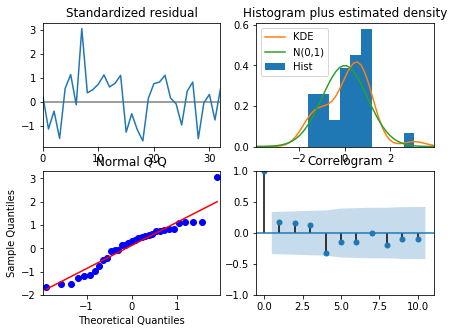

In [9]:
fitted.plot_diagnostics(figsize=(7,5))
plt.savefig('residualspib.png')

### Modelo del Inflación

Para modelar el IPC se decide utilizar un modelo autoregresivo integrado de media movil agregandole el efecto estacional, se buscan los valores óptimos para los parametros p, d, q, P, D, Q. El criterio para la selección de estos es el AIC. Como se puede observar en la siguiente tabla, el menor AIC es generado con un SARIMAX(1, 0, 1)x(2, 0, 2) (a si mismo es el menor BIC, aunque este no sea el criterio que se esta empleando para la selección).

In [10]:
trainipc = ipc[:len(ipc)-12]
testipc = ipc[len(ipc)-12:]

In [11]:
modelinf = pm.auto_arima(trainipc, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=12,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=1, 
                      
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)


Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 0, 1, 12); AIC=-78.375, BIC=-62.989, Fit time=1.238 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=2.133, BIC=7.261, Fit time=0.144 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=-73.853, BIC=-63.596, Fit time=0.735 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=-59.170, BIC=-48.912, Fit time=0.411 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=-59.604, BIC=-46.783, Fit time=0.509 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(2, 0, 1, 12); AIC=-77.114, BIC=-59.164, Fit time=2.665 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 0, 0, 12); AIC=-62.781, BIC=-49.959, Fit time=0.986 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 0, 2, 12); AIC=-79.117, BIC=-61.167, Fit time=2.749 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 0, 2, 12); AIC=-75.423, BIC=-60.037, Fit time=2.130 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(1, 0, 2

A continuación se presenta un resumen del modelo:

In [12]:
print(modelinf.summary())


                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                   96
Model:             SARIMAX(1, 0, 0)x(1, 0, 2, 12)   Log Likelihood                  46.166
Date:                            Mon, 09 Sep 2019   AIC                            -80.331
Time:                                    16:05:08   BIC                            -64.945
Sample:                                         0   HQIC                           -74.112
                                             - 96                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0017      0.011      0.159      0.874      -0.019       0.022
ar.L1          0.4445      0.085   

Se realiza un backtest pronosticando 24 meses atras de la fecha final de la serie de tiempo. 

/home/carlos/Documentos/venv/lib/python3.5/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


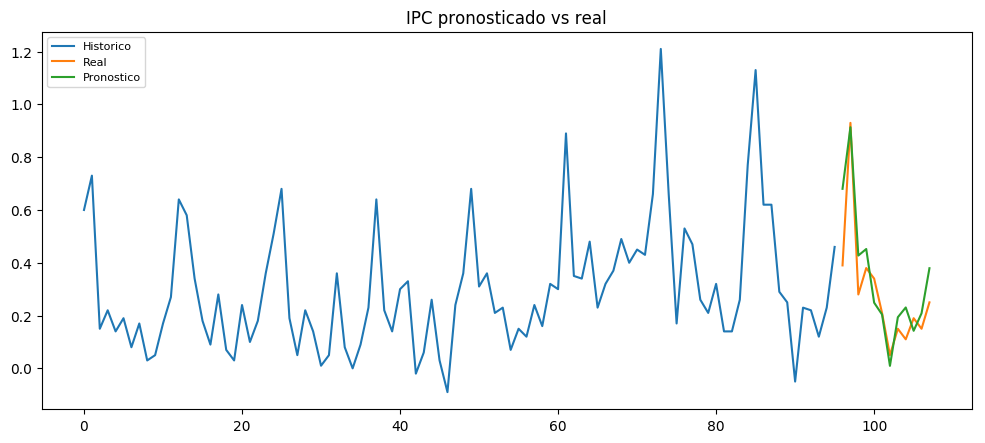

In [13]:
model = SARIMAX(trainipc, order=(1,0, 0)  , seasonal_order=(1, 0,2, 12))
fitted = model.fit(disp=-1)  
fc = fitted.forecast(24, alpha=0.05)
fc_series = pd.Series(fc, index=testipc.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(trainipc, label='Historico')
plt.plot(testipc, label='Real')
plt.plot(fc_series, label='Pronostico')
plt.title('IPC pronosticado vs real')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Grafica diagnostico del modelo

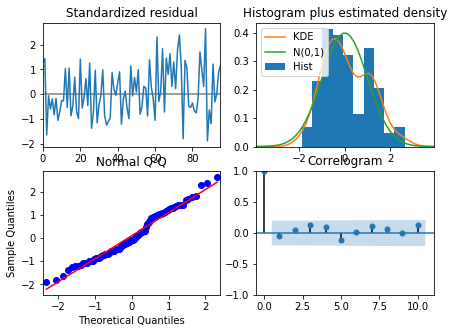

In [14]:
modelinf.plot_diagnostics(figsize=(7,5))
plt.savefig('residualsinf.png')

### Modelo desempleo

Para modelar el desempleo se decide utilizar un modelo estacional autoregresivo integrado de media movil, se buscan los valores óptimos para los parametros  (p, d, q) × (P, D, Q). El criterio para la selección de estos es el AIC. Como se puede observar en la siguiente tabla, el menor AIC es generado con un SARIMAX(2,0,0)x(0,1,1) (a si mismo es el menor BIC, aunque este no sea el criterio que se esta empleando para la selección)

In [15]:
traindes = des[:35]
testdes = des[35:]

In [16]:
 modeldes = pm.auto_arima(traindes, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=4,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      D = 1,
                      max_D = 5,
                      start_P=1,  
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                     )

Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 1, 4); AIC=56.888, BIC=65.492, Fit time=0.695 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 4); AIC=65.018, BIC=67.886, Fit time=0.027 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 4); AIC=64.159, BIC=69.895, Fit time=0.091 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 4); AIC=65.047, BIC=70.783, Fit time=0.433 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 1, 4); AIC=55.342, BIC=62.512, Fit time=0.412 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 0, 4); AIC=66.972, BIC=72.708, Fit time=0.108 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 2, 4); AIC=56.684, BIC=65.287, Fit time=0.550 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 2, 4); AIC=58.249, BIC=68.286, Fit time=1.065 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 1, 1, 4); AIC=54.828, BIC=63.432, Fit time=0.680 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(0, 1, 1, 4); AIC=52.861, BIC=6

A continuación se presenta un resumen de este modelo.

In [17]:
traindes = des[:30]
testdes = des[30:]

In [18]:
print(modeldes.summary())

                                 Statespace Model Results                                
Dep. Variable:                                 y   No. Observations:                   35
Model:             SARIMAX(2, 0, 0)x(1, 1, 1, 4)   Log Likelihood                 -20.329
Date:                           Mon, 09 Sep 2019   AIC                             52.657
Time:                                   16:05:28   BIC                             61.261
Sample:                                        0   HQIC                            55.462
                                            - 35                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0071      0.603     -0.012      0.991      -1.190       1.175
ar.L1          0.3653      0.863      0.423

El backtesting sugiere que se un SARIMAX(2, 0, 0)x(1,1, 0) se puede ajustar mejor a las dinamicas de la tasa del desempleo que el sugerido por el optimizador. A continuación se presenta el Backtest de este modelo y su resumen.

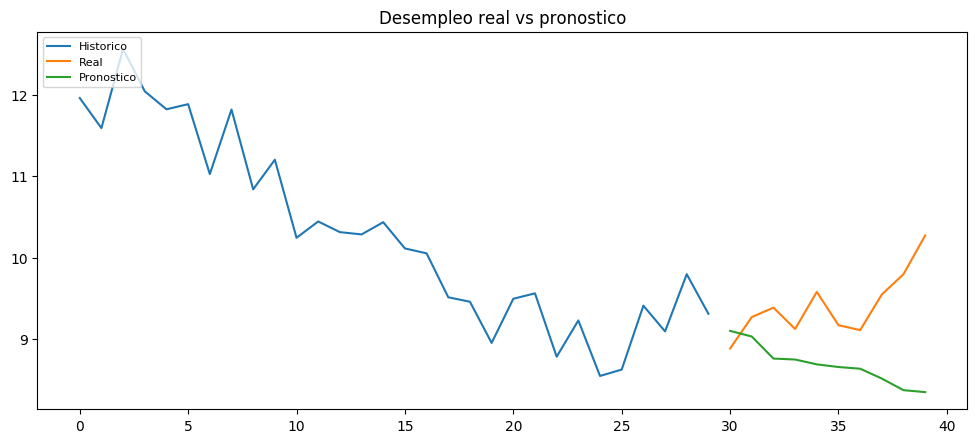

In [19]:
model = SARIMAX(traindes, order=(2,0, 0)  , seasonal_order=(1, 1,1, 4))
fitted = model.fit(disp=-1)  
fc = fitted.forecast(10, alpha=0.05)
fc_series = pd.Series(fc, index=testdes.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(traindes, label='Historico')
plt.plot(testdes, label='Real')
plt.plot(fc_series, label='Pronostico')
plt.title('Desempleo real vs pronostico')
plt.legend(loc='upper left', fontsize=8)
plt.show()

El backtest del modelo muestra que no este no sigue las dinamicas actuales del desempleo (esta cambiando su tendencia) para ajustarlo a esto se decide probar ocn un  Sarimax(2,0,0)x(1,1,0). Este modelo tiene un AIC (criterio de selección en este caso) similar al del modelo sugerido por el auto arima. Como se puede observar a continuación el modelo se ajusta mejor con respecto al anterior.

Como se puede observar en el resumen los coeficientes de este modelo son significativos. 

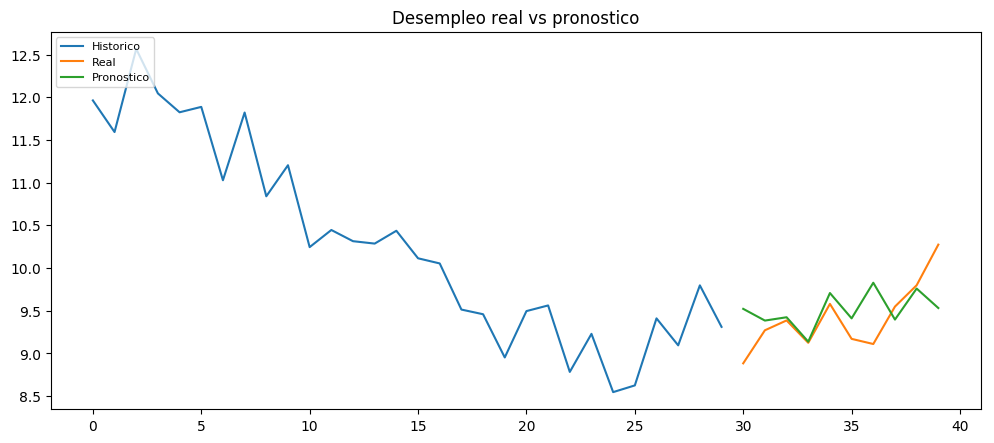

In [20]:
model = SARIMAX(traindes, order=(2,0, 0)  , seasonal_order=(1, 1,0, 4))
fitted = model.fit(disp=-1)  
fc = fitted.forecast(10, alpha=0.05)
fc_series = pd.Series(fc, index=testdes.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(traindes, label='Historico')
plt.plot(testdes, label='Real')
plt.plot(fc_series, label='Pronostico')
plt.title('Desempleo real vs pronostico')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [21]:
print(fitted.summary())

                                 Statespace Model Results                                
Dep. Variable:                               des   No. Observations:                   30
Model:             SARIMAX(2, 0, 0)x(1, 1, 0, 4)   Log Likelihood                 -22.170
Date:                           Mon, 09 Sep 2019   AIC                             52.340
Time:                                   16:05:31   BIC                             57.373
Sample:                                        0   HQIC                            53.789
                                            - 30                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2603      0.221      1.177      0.239      -0.173       0.694
ar.L2          0.5874      0.206      2.848

Grafico diagnostico residuales del modelo

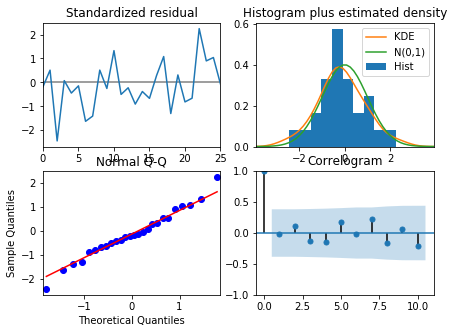

In [22]:
fitted.plot_diagnostics(figsize=(7,5))
plt.savefig('residualsdes.png')

### Modelo DTF

Es espera que la DTF tenga una relación alta con la inflación, esto debido a que el objetivo principal del Banco de la Republica de Colombia es alcanzar inflación objetivo, para esto utiliza como instrumento la tasa de intervención que afecta las demas tasas de la economía.
Para determinar si esta relación es cierta y significativa se decide utilizar una regresión lineal simple.

In [23]:
inf_values = ipca
dtf_values = dtfm

In [24]:
modeldtf = sm.OLS(dtf_values,inf_values)

A continuación se muestra el resumen de la regresión lineal de la DTF contra la inflación (anual), se puede observar que el R cuadrado alto y el coeficiente de la inflación es significativo.

In [25]:
resdtf = modeldtf.fit()
print(resdtf.summary())

                                 OLS Regression Results                                
Dep. Variable:                    dtf   R-squared (uncentered):                   0.963
Model:                            OLS   Adj. R-squared (uncentered):              0.963
Method:                 Least Squares   F-statistic:                              2775.
Date:                Mon, 09 Sep 2019   Prob (F-statistic):                    2.34e-78
Time:                        16:05:33   Log-Likelihood:                         -148.12
No. Observations:                 108   AIC:                                      298.2
Df Residuals:                     107   BIC:                                      300.9
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Modelo IBR

Para modelar la IBR se sigue la misma logica utilizada en la DTF.

In [26]:
inf_values = ipca.values
ibr_values = ibrm.values

In [27]:
modelibr = sm.OLS(ibr_values,inf_values)

A continuación se muestra el resumen de la regresión lineal de la IBR contra la inflación (anual), se puede observar que el R cuadrado alto y el coeficiente de la inflación es significativo.

In [28]:
resibr = modelibr.fit()
print(resibr.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.973
Method:                 Least Squares   F-statistic:                              3922.
Date:                Mon, 09 Sep 2019   Prob (F-statistic):                    3.86e-86
Time:                        16:05:33   Log-Likelihood:                         -126.93
No. Observations:                 108   AIC:                                      255.9
Df Residuals:                     107   BIC:                                      258.6
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## Pronosticos

### Pronostico PIB

Se utiliza el modelo establecido en la sección 1.1.1 para proyectar los proximos 12 trimestres del PIB. En la siguiente grafica se puede observar este pronostico y bandas con 90% de confianza.

In [29]:
didx = pd.DatetimeIndex(start ='2005-12-31', freq ='Q', 
                           periods = 53)

/home/carlos/Documentos/venv/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  


In [30]:
pib.index = didx

In [31]:
def plot_ts(historic, predict, titulo, ylabel, path, porcentage = False):
    
    fig, ax = plt.subplots()

    ax.set_xlabel('Fechas', fontsize = 12)
    ax.set_ylabel(ylabel, fontsize = 12)
    ax.plot(historic, label = 'Histórico')
    ax.plot(predict, color='orange', label = 'Pronostico')
    ax.legend(loc='best', fontsize = 13)
    ax.tick_params(axis="x", labelsize=10)
    ax.tick_params(axis="y", labelsize=10)


    fig.suptitle(titulo, fontsize = 17)
    if porcentage:
        fig.gca().yaxis.set_major_formatter(PercentFormatter(decimals=1))

    plt.grid()
    plt.savefig(path)
    plt.show()


/home/carlos/Documentos/venv/lib/python3.5/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/home/carlos/Documentos/venv/lib/python3.5/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


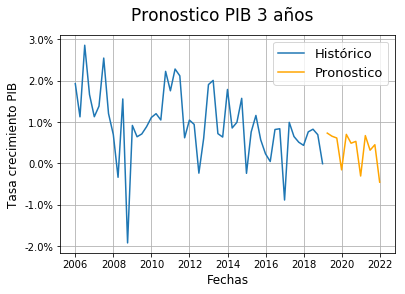

In [32]:
model = SARIMAX(pib, order=(0, 0 ,0) , seasonal_order=(0 ,2,1,4))
fitted = model.fit(disp=-1)  
fcpib = fitted.forecast(12, alpha=0.10)
df = pd.DataFrame(fcpib,  index = pd.date_range(start ='2019-01-31', freq ='Q', 
                           periods = 12))

kwargs = dict(historic = pib,
              predict = df,
              titulo = 'Pronostico PIB 3 años',
              ylabel = 'Tasa crecimiento PIB',
              path = 'pro_pib.png',
              porcentage = True)

plot_ts(**kwargs)

Los siguietnes son los vales del PIB para los doce trimestres siguientes a partir del 2018. 

In [33]:
fcpib

2019-03-31    0.730732
2019-06-30    0.655556
2019-09-30    0.611746
2019-12-31   -0.157697
2020-03-31    0.700478
2020-06-30    0.486384
2020-09-30    0.530927
2020-12-31   -0.306551
2021-03-31    0.670224
2021-06-30    0.317213
2021-09-30    0.450108
2021-12-31   -0.455404
Freq: Q-DEC, dtype: float64

### Pronostico inflación 

Se utiliza el modelo establecido en la sección 1.1.2 para proyectar los proximos 12 trimestres de la inflación. En la siguiente grafica se puede observar este pronostico.

In [34]:
fechainf = pd.date_range(start ='2010-01-31', freq ='M', 
                           periods = 108)

In [35]:
ipc.index = fechainf

/home/carlos/Documentos/venv/lib/python3.5/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


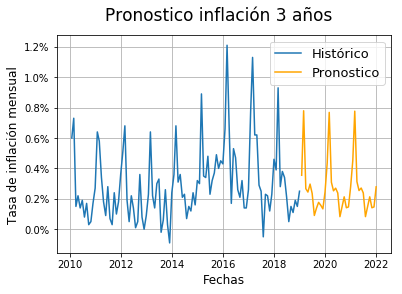

In [36]:
model = SARIMAX(ipc, order=(1,0, 0)  , seasonal_order=(1, 0,2, 12))

fitted = model.fit(disp=-1)  
fcinf = fitted.forecast(36, alpha=0.10)
inflacion = pd.DataFrame(fcinf, index = pd.date_range(start ='2019-01-31', freq ='M', 
                           periods = 36))

kwargs = dict(historic = ipc,
              predict = inflacion,
              titulo = 'Pronostico inflación 3 años',
              ylabel = 'Tasa de inflación mensual',
              path = 'foo.png',
              porcentage = True)

plot_ts(**kwargs)


In [37]:
fcinf

2019-01-31    0.354772
2019-02-28    0.779114
2019-03-31    0.266925
2019-04-30    0.244434
2019-05-31    0.296898
2019-06-30    0.235307
2019-07-31    0.090556
2019-08-31    0.139008
2019-09-30    0.176745
2019-10-31    0.157453
2019-11-30    0.133783
2019-12-31    0.244824
2020-01-31    0.435881
2020-02-29    0.768354
2020-03-31    0.309025
2020-04-30    0.252622
2020-05-31    0.270020
2020-06-30    0.238130
2020-07-31    0.082613
2020-08-31    0.149008
2020-09-30    0.213159
2020-10-31    0.141221
2020-11-30    0.146693
2020-12-31    0.278984
2021-01-31    0.452719
2021-02-28    0.776441
2021-03-31    0.313090
2021-04-30    0.254593
2021-05-31    0.270924
2021-06-30    0.238524
2021-07-31    0.082828
2021-08-31    0.149058
2021-09-30    0.213109
2021-10-31    0.141178
2021-11-30    0.146630
2021-12-31    0.278842
Freq: M, dtype: float64

Los siguietnes son los vales de la inflación para los doce trimestres siguientes a partir del 2018. 

In [38]:
#plt.rc('figure', figsize=(6, 5))
#plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}) old approach
#plt.text(0.01, 0.05, str(fitted.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
#plt.axis('off')
#plt.tight_layout()
#plt.savefig('ARIMAipc.png')

### Pronostico desempleo

Se utiliza el modelo establecido en la sección 1.1.3 para proyectar los proximos 12 trimestres de la tasa de desempleo. En la siguiente grafica se puede observar este pronostico y bandas con 90% de confianza.

In [39]:
fechades = pd.date_range(start ='2009-01-31', freq ='Q', 
                           periods = 40 )

In [40]:
des.index = fechades

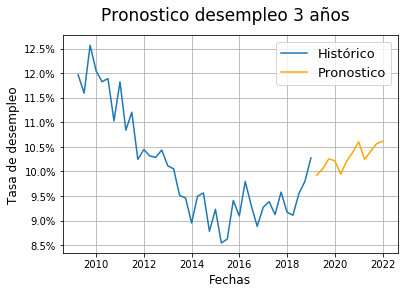

In [41]:
model = SARIMAX(des, order=(2, 0 ,0) , seasonal_order=(1 ,1,0,4))
fitted = model.fit(disp=-1)  
fcdes = fitted.forecast(12, alpha=0.10)
desempleo = pd.DataFrame(fcdes, index = pd.date_range(start ='2019-01-31', freq ='Q', 
                           periods = 12 ))
kwargs = dict(historic = des,
              predict = desempleo,
              titulo = 'Pronostico desempleo 3 años',
              ylabel = 'Tasa de desempleo',
              path = 'pro_des.png',
              porcentage = True)

plot_ts(**kwargs)



In [42]:
fcdes

2019-03-31     9.925959
2019-06-30    10.053654
2019-09-30    10.256082
2019-12-31    10.218815
2020-03-31     9.946807
2020-06-30    10.213451
2020-09-30    10.387686
2020-12-31    10.603063
2021-03-31    10.248057
2021-06-30    10.404746
2021-09-30    10.564463
2021-12-31    10.611399
Freq: Q-DEC, dtype: float64

### Pronostico DTF

Para pronosticar la DTF se utiliza el pronostico previo de la inflación para los 3 años y el coeficiente hallado con la regresión lineal de la DTF con la inflación; el pronostico de la inflación es suavisado ya que tiene una volatilidad alta.

In [43]:
pibarr = pib.values
desarr = des.values
infarr = ipc.values
coefdtf = resdtf.params
brentarr = brent.tail(40).values
trmarr = macro['trm'].values

In [44]:
inft = np.concatenate((infarr, fcinf), axis=0)
pibt = np.concatenate((pibarr, fcpib), axis=0)
dest = np.concatenate((desarr, fcdes), axis=0)

suinf = list()

In [45]:
infa = inft/100+1
ipca = list()

In [46]:
for i in range(12,len(infa)+1):
    x = np.prod(infa[i-12:i])
    ipca.append(x)
    

In [47]:
ipca = np.asarray(ipca)
ipca =(ipca-1)*100
np.around(ipca, decimals = 2)

array([2.83, 2.87, 2.72, 2.92, 2.88, 2.82, 2.92, 2.91, 2.76, 2.98, 3.03,
       3.04, 3.13, 3.  , 3.1 , 2.95, 2.81, 2.95, 2.8 , 2.74, 2.76, 2.89,
       2.86, 2.68, 2.4 , 2.12, 2.08, 2.11, 2.2 , 2.28, 2.48, 2.45, 2.46,
       2.35, 2.3 , 2.21, 2.36, 2.5 , 2.54, 2.63, 2.85, 2.76, 2.66, 2.75,
       2.84, 2.7 , 2.92, 3.17, 3.26, 3.19, 3.41, 3.45, 3.43, 3.71, 3.71,
       3.97, 4.2 , 4.58, 4.75, 5.05, 5.17, 5.54, 5.88, 6.21, 6.03, 6.08,
       6.33, 6.27, 6.1 , 5.92, 5.65, 5.32, 5.14, 5.26, 5.17, 5.13, 5.6 ,
       5.35, 5.12, 4.8 , 4.82, 4.71, 4.69, 4.79, 4.99, 4.6 , 4.39, 4.04,
       3.79, 3.84, 3.8 , 3.91, 3.82, 3.71, 3.78, 3.7 , 3.48, 3.45, 3.29,
       3.28, 3.14, 3.09, 3.12, 3.16, 3.15, 3.22, 3.19, 3.17, 3.16, 3.25,
       3.24, 3.28, 3.29, 3.26, 3.26, 3.25, 3.26, 3.3 , 3.29, 3.3 , 3.33,
       3.35, 3.36, 3.36, 3.37, 3.37, 3.37, 3.37, 3.37, 3.37, 3.37, 3.37,
       3.37])

In [48]:
dtfarr =dtfm.tail(len(ipca)-36)

In [49]:
fcdtf = np.zeros(shape=(36,))

In [50]:
dtft = np.concatenate((dtfarr, fcdtf), axis=0)


In [51]:
for i in range(len(dtft)-36,len(dtft)): 
    dtft[i] = dtft[i-1]+(ipca[i]-ipca[i-1])*1
      
    
    

Serie historica de la DTF, adionando el pronostico realizado:

In [52]:
dtft

array([3.5       , 3.48      , 3.46      , 3.59      , 3.74      ,
       3.88      , 4.1       , 4.21      , 4.49      , 4.61      ,
       4.72      , 5.08      , 5.12      , 5.13      , 5.27      ,
       5.36      , 5.47      , 5.45      , 5.45      , 5.44      ,
       5.41      , 5.32      , 5.42      , 5.31      , 5.22      ,
       5.12      , 4.82      , 4.57      , 4.21      , 3.98      ,
       3.94      , 3.98      , 4.07      , 4.07      , 4.02      ,
       4.03      , 4.06      , 4.03      , 3.97      , 3.89      ,
       3.81      , 3.79      , 3.94      , 4.06      , 4.04      ,
       4.26      , 4.33      , 4.36      , 4.34      , 4.47      ,
       4.45      , 4.41      , 4.51      , 4.42      , 4.4       ,
       4.52      , 4.47      , 4.41      , 4.72      , 4.92      ,
       5.24      , 5.74      , 6.25      , 6.35      , 6.65      ,
       6.83      , 6.91      , 7.26      , 7.19      , 7.18      ,
       7.09      , 7.01      , 6.92      , 6.94      , 6.78   

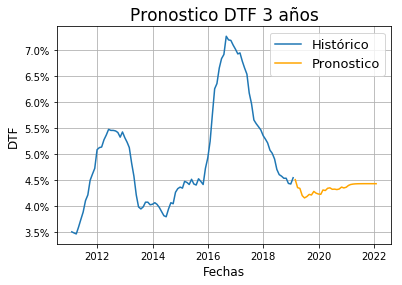

In [53]:
dtft = pd.DataFrame(dtft, index = pd.date_range(start ='2011-01-31', freq ='M', 
                           periods = 133 ))

plt.figure()
plt.plot(dtft[:-36], label = 'Histórico')
plt.plot(dtft[97:], color='orange', label = 'Pronostico')
plt.legend(loc='best', fontsize = 13)
plt.title('Pronostico DTF 3 años', fontsize = 17)
plt.xlabel('Fechas', fontsize = 12)
plt.ylabel('DTF', fontsize = 12)
plt.yticks(fontsize = 10)
plt.xticks(fontsize = 10)
plt.grid()
plt.gca().yaxis.set_major_formatter(PercentFormatter(decimals=1))
plt.savefig('pro_dtf.png')
plt.show()




Backtest pronostico de la DTF:

In [54]:
btdft =  np.zeros(shape=(50,))
btdft[0] = dtfm[len(dtfm)-50]

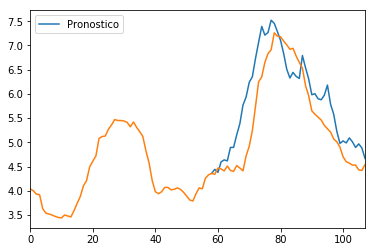

In [55]:
for i in range(59,108):
    btdft[i-58] = btdft[i-59]+(ipca[i-11]-ipca[i-12])*1
     

btdft = pd.DataFrame(btdft, index = range(58,108), columns = ['Pronostico'])
btdft.plot()
dtfm.plot()
plt.show()
plt.show()

### Pronostico IBR

Para pronosticar la DTF se utiliza el pronostico previo de la inflación para los 3 años y el coeficiente hallado con la regresión lineal de la DTF con la inflación; el pronostico de la inflación es suavisado ya que tiene una volatilidad alta.

In [56]:
fcibr = np.zeros(shape=(36,))
ibrarr =ibrm.tail(len(ipca)-36)
coefibr = resibr.params
ibrt = np.concatenate((ibrarr, fcibr), axis=0)

In [57]:
for i in range(len(ibrt)-36,len(ibrt)): 
    ibrt[i] = ibrt[i-1]+(ipca[i]-ipca[i-1])*1
      

    

A conituación se presenta la serie historica de la IBR adionando el pronostico realizado:

(array([2., 3., 4., 5., 6., 7., 8.]), <a list of 7 Text yticklabel objects>)

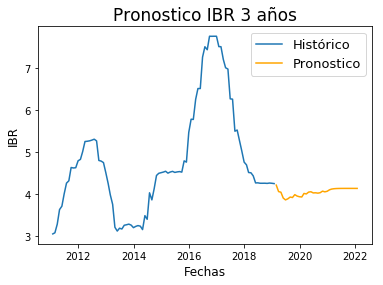

In [58]:
ibrt = pd.DataFrame(ibrt, index = pd.date_range(start ='2011-01-31', freq ='M', 
                           periods = 133 ))
plt.figure()
plt.plot(ibrt[:-36], label = 'Histórico')
plt.plot(ibrt[97:], color='orange', label = 'Pronostico')
plt.legend(loc='best', fontsize = 13)
plt.title('Pronostico IBR 3 años', fontsize = 17)
plt.xlabel('Fechas', fontsize = 12)
plt.ylabel('IBR', fontsize = 12)
plt.yticks(fontsize = 10)




Backtest del modelo de la IBR:

In [59]:
btibr =  np.zeros(shape=(50,))
btibr[0] = ibrm[len(ibrm)-50]

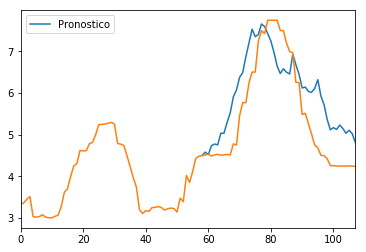

In [60]:
for i in range(59,108):
    btibr[i-58] = btibr[i-59]+(ipca[i-11]-ipca[i-12])*1
     

btibr = pd.DataFrame(btibr, index = range(58,108), columns = ['Pronostico'])
btibr.plot()
ibrm.plot()
plt.show()